In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import climlab
from climlab import constants as const

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Ts: (90, 1) 
  Tatm: (90, 1) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 0.9993368783782377 years.


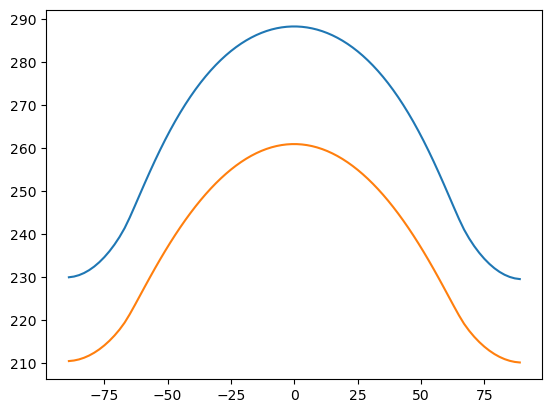

In [2]:
ebm = climlab.GreyRadiationModel(num_lev=1, num_lat=90)
insolation = climlab.radiation.AnnualMeanInsolation(domains=ebm.Ts.domain)
ebm.add_subprocess('insolation', insolation)
ebm.subprocess.SW.flux_from_space = ebm.subprocess.insolation.insolation
print(ebm)

#  add a fixed relative humidity process
#  (will only affect surface evaporation)
h2o = climlab.radiation.ManabeWaterVapor(state=ebm.state, **ebm.param)
ebm.add_subprocess('H2O', h2o)

#  Add surface heat fluxes
shf = climlab.surface.SensibleHeatFlux(state=ebm.state, Cd=3E-4)
lhf = climlab.surface.LatentHeatFlux(state=ebm.state, Cd=3E-4)
# couple water vapor to latent heat flux process
lhf.q = h2o.q
ebm.add_subprocess('SHF', shf)
ebm.add_subprocess('LHF', lhf)

ebm.integrate_years(1)

plt.plot(ebm.lat, ebm.Ts)
plt.plot(ebm.lat, ebm.Tatm)

Integrating for 1095 steps, 1095.7266 days, or 3.0 years.


Total elapsed time is 3.997347513512951 years.


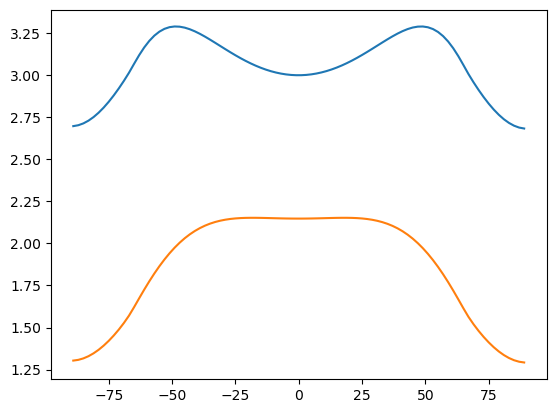

In [3]:
co2ebm = climlab.process_like(ebm)
co2ebm.subprocess['LW'].absorptivity = ebm.subprocess['LW'].absorptivity*1.1

co2ebm.integrate_years(3.)

#  no heat transport but with evaporation -- no polar amplification
plt.plot(ebm.lat, co2ebm.Ts - ebm.Ts)
plt.plot(ebm.lat, co2ebm.Tatm - ebm.Tatm)


climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Ts: (90, 1) 
  Tatm: (90, 1) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   SHF: <class 'climlab.surface.turbulent.SensibleHeatFlux'>
   LHF: <class 'climlab.surface.turbulent.LatentHeatFlux'>
   diffusion: <class 'climlab.dynamics.meridional_advection_diffusion.MeridionalDiffusion'>

Integrating for 1095 steps, 1095.7266 days, or 3 years.


Total elapsed time is 3.997347513512951 years.


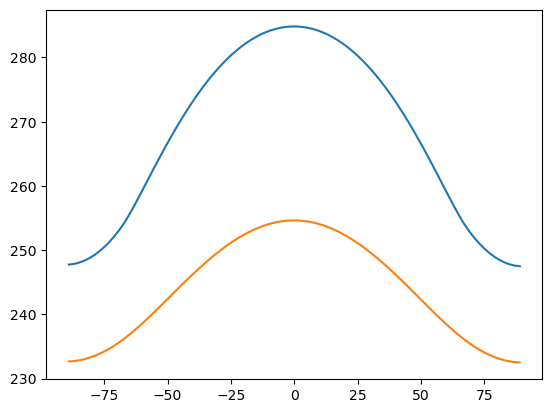

In [4]:
diffebm = climlab.process_like(ebm)
# thermal diffusivity in W/m**2/degC
D = 0.6
# meridional diffusivity in m**2/s
K = D / diffebm.Tatm.domain.heat_capacity * const.a**2
d = climlab.dynamics.MeridionalDiffusion(K=K, state={'Tatm': diffebm.Tatm}, **diffebm.param)
diffebm.add_subprocess('diffusion', d)
print(diffebm)

diffebm.integrate_years(3)

plt.plot(diffebm.lat, diffebm.Ts)
plt.plot(diffebm.lat, diffebm.Tatm)


/var/folders/z_/36cc8kqx7pqf8lzjc5cp2cf00000gn/T/ipykernel_28492/4142479116.py:6: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  return ( 1E-15 * 2 * np.math.pi * const.a**2 * integrate.cumtrapz( np.cos(lat_rad)*energy_in,


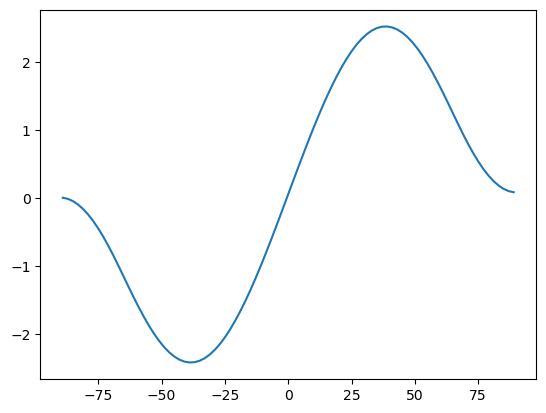

In [5]:
def inferred_heat_transport( energy_in, lat_deg ):
    '''Returns the inferred heat transport (in PW) by integrating the net energy imbalance from pole to pole.'''
    from scipy import integrate
    from climlab import constants as const
    lat_rad = np.deg2rad( lat_deg )
    return ( 1E-15 * 2 * np.math.pi * const.a**2 * integrate.cumtrapz( np.cos(lat_rad)*energy_in,
            x=lat_rad, initial=0. ) )

#  Plot the northward heat transport in this model
Rtoa = np.squeeze(diffebm.timeave['ASR'] - diffebm.timeave['OLR'])
plt.plot(diffebm.lat, inferred_heat_transport(Rtoa, diffebm.lat))


Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.


Total elapsed time is 8.99676981465997 years.


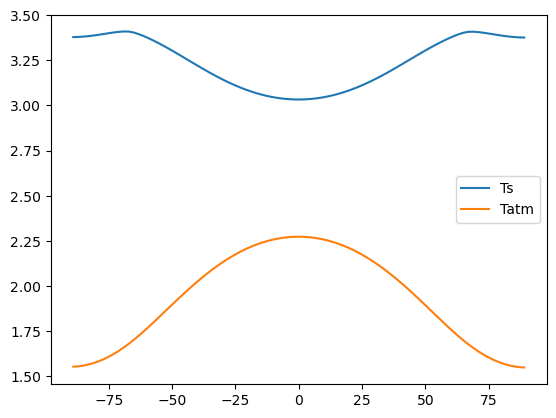

In [6]:
##  Now warm it up!
co2diffebm = climlab.process_like(diffebm)
co2diffebm.subprocess['LW'].absorptivity = diffebm.subprocess['LW'].absorptivity*1.1

co2diffebm.integrate_years(5)

#  with heat transport and evaporation
#   Get some modest polar amplifcation of surface warming
#    but larger equatorial amplification of atmospheric warming
#    Increased atmospheric gradient = increased poleward flux.
plt.plot(diffebm.lat, co2diffebm.Ts - diffebm.Ts, label='Ts')
plt.plot(diffebm.lat, co2diffebm.Tatm - diffebm.Tatm, label='Tatm')
plt.legend()
